# Análise Exploratória

O Bitcoin é uma moeda digital descentralizada, criada em 2009 por uma entidade sob o pseudônimo de Satoshi Nakamoto, projetada para permitir transações financeiras sem a necessidade de intermediários, como bancos ou governos. Baseado na tecnologia blockchain, o Bitcoin utiliza um registro público e distribuído para garantir a transparência, segurança e imutabilidade das transações. Seu fornecimento total é limitado a 21 milhões de unidades, e novas moedas são geradas por meio do processo de mineração, no qual computadores resolvem problemas criptográficos complexos. Considerado tanto uma forma de pagamento quanto uma reserva de valor, o Bitcoin tem sido amplamente adotado como um ativo de investimento e um mecanismo de proteção contra inflação em alguns contextos econômicos.

Iremos utilizar a biblioteca ccxt para obter dados de mercado sobre o Bitcoin. A biblioteca CCXT (CryptoCurrency eXchange Trading Library) é uma ferramenta unificada para acessar APIs de diversas exchanges de criptomoedas, facilitando a negociação, obtenção de dados de mercado e gerenciamento de contas de forma padronizada em múltiplas plataformas.

In [1]:
# Instalar as dependências necessárias para o projeto
%pip install ccxt
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar as bibliotecas necessárias
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests
from io import StringIO

A função fetch_all_binance_data coleta todos os dados históricos de preço no formato OHLCV (Open, High, Low, Close, Volume) para o par de negociação BTC/USDT na Binance, com granularidade diária por padrão. Ela inicializa a conexão com a exchange usando a biblioteca CCXT e começa a buscar dados a partir de 1º de janeiro de 2017. Em um loop contínuo, ela coleta dados em blocos de até 1000 registros por vez (limite da API), avançando o ponto inicial (since) após cada lote e adicionando os dados à lista all_data. Após concluir o processo, os dados são convertidos em um DataFrame do Pandas, com os timestamps formatados para o tipo de data, e o resultado final é ordenado cronologicamente antes de ser retornado. O uso de time.sleep(1) reduz a carga na API durante a execução.

In [3]:
# =============================================================================
# Função para baixar dados de OHLCV do par BTC/USDT (Binance)
# OHLCV = Open, High, Low, Close, Volume
# =============================================================================
def fetch_all_binance_data(symbol="BTC/USDT", timeframe="1d"):
    exchange = ccxt.binance()
    since = exchange.parse8601("2017-01-01T00:00:00Z")
    all_data = []
    max_limit = 1000

    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=max_limit)
        if not ohlcv:
            break
        all_data.extend(ohlcv)
        since = ohlcv[-1][0] + 1  # atualiza "since" para continuar baixando
        print(f"Baixados {len(all_data)} registros...")
        time.sleep(1)  # pequeno intervalo para evitar limite de requisições

    # Log de debug: vamos ver as primeiras 5 linhas brutas de all_data
    print("\nExemplo de registros de 'all_data' (primeiros 5):")
    print(all_data[:5])

    # Monta o DataFrame
    df = pd.DataFrame(all_data, columns=["timestamp", "open", "high", "low", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

    # Ordena e mantém apenas as colunas desejadas
    df = df[["timestamp", "open", "high", "low", "close", "volume"]].sort_values("timestamp")
    return df

In [4]:
# Coletar os dados de cotação
btc_data = fetch_all_binance_data()

Baixados 1000 registros...
Baixados 2000 registros...
Baixados 2748 registros...

Exemplo de registros de 'all_data' (primeiros 5):
[[1502928000000, 4261.48, 4485.39, 4200.74, 4285.08, 795.150377], [1503014400000, 4285.08, 4371.52, 3938.77, 4108.37, 1199.888264], [1503100800000, 4108.37, 4184.69, 3850.0, 4139.98, 381.309763], [1503187200000, 4120.98, 4211.08, 4032.62, 4086.29, 467.083022], [1503273600000, 4069.13, 4119.62, 3911.79, 4016.0, 691.74306]]


O volume retornado pela API fetch_ohlcv da Binance (e outras exchanges) refere-se ao volume de negociação em termos da criptomoeda base no par de negociação. No caso do par BTC/USDT, o volume representa a quantidade total de BTC negociado no período especificado (por exemplo, um dia no timeframe '1d').

Esse volume não é diretamente em dólares, mas pode ser convertido multiplicando o volume de BTC pelo preço médio (por exemplo, o preço de fechamento). Também não representa a quantidade de transações, mas sim a soma total da quantidade de criptomoeda negociada em todas as transações no período.

In [5]:
# Dados incluem final de semana
btc_data.head(7)

,timestamp,open,high,low,close,volume
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
5,2017-08-22,4016.00,4104.82,3400.00,4040.00,966.684858
6,2017-08-23,4040.00,4265.80,4013.89,4114.01,1001.136565


In [6]:
btc_data.tail()

,timestamp,open,high,low,close,volume
2743,2025-02-19,95671.74,96899.99,95029.99,96644.37,16438.50954
2744,2025-02-20,96644.37,98711.36,96415.09,98305.00,17057.39177
2745,2025-02-21,98305.01,99475.00,94871.95,96181.98,32249.28140
2746,2025-02-22,96181.99,96980.00,95770.49,96551.01,11268.17708
2747,2025-02-23,96551.01,96650.00,95657.05,95910.59,5144.19706


In [7]:
# Estatísticas descritivas
descriptive_stats = btc_data.describe()
display(descriptive_stats)

,timestamp,open,high,low,close,volume
count,2748,2748.000000,2748.000000,2748.000000,2748.000000,2748.000000
mean,2021-05-21 12:00:00,28404.222493,29082.978148,27681.042755,28437.627001,67268.195869
min,2017-08-17 00:00:00,3188.010000,3276.500000,2817.000000,3189.020000,228.108068
25%,2019-07-04 18:00:00,8645.372500,8856.930000,8323.347500,8646.430000,27683.916818
50%,2021-05-21 12:00:00,20733.040000,21324.935000,20242.305000,20757.075000,43214.096711
75%,2023-04-08 06:00:00,42897.345000,43802.865000,42000.475000,42953.700000,70431.121003
max,2025-02-23 00:00:00,106143.820000,109588.000000,105321.490000,106143.820000,760705.362783
std,NaN,23977.617191,24486.198528,23458.443977,24007.757338,79585.884667


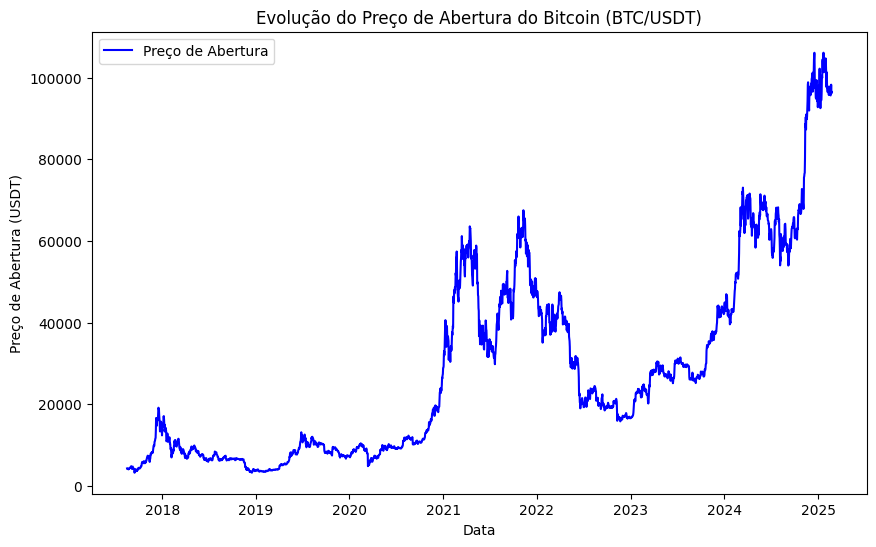

In [8]:
# Visualização do Preço de Abertura ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(
    btc_data["timestamp"], btc_data["open"], label="Preço de Abertura", color="blue"
)
plt.xlabel("Data")
plt.ylabel("Preço de Abertura (USDT)")
plt.title("Evolução do Preço de Abertura do Bitcoin (BTC/USDT)")
plt.legend()
plt.show()

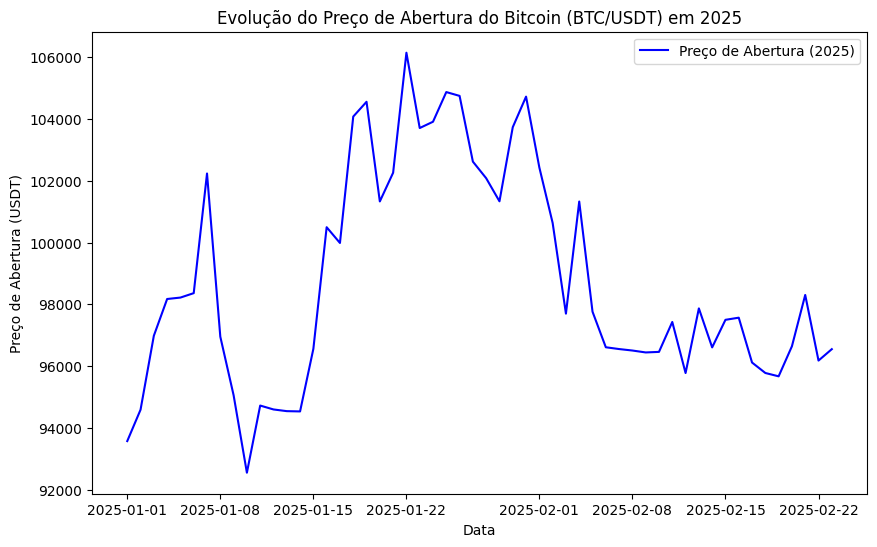

In [9]:
# Filtrando apenas os dados de 2025
btc_data_2025 = btc_data[btc_data["timestamp"].dt.year == 2025]

# Visualização do Preço de Abertura ao longo do tempo em 2025
plt.figure(figsize=(10, 6))
plt.plot(
    btc_data_2025["timestamp"],
    btc_data_2025["open"],
    label="Preço de Abertura (2025)",
    color="blue",
)
plt.xlabel("Data")
plt.ylabel("Preço de Abertura (USDT)")
plt.title("Evolução do Preço de Abertura do Bitcoin (BTC/USDT) em 2025")
plt.legend()
plt.show()

In [10]:
# Incluindo colunas de média móvel (moving average) de 3 dias
btc_data["open_ma3"] = btc_data["open"].rolling(window=3).mean()
btc_data["close_ma3"] = btc_data["close"].rolling(window=3).mean()
btc_data["volume_ma3"] = btc_data["volume"].rolling(window=3).mean()
btc_data["high_ma3"] = btc_data["high"].rolling(window=3).mean()
btc_data["low_ma3"] = btc_data["low"].rolling(window=3).mean()

In [11]:
# Criando colunas de shift para o preço de abertura e fechamento do dia anterior
btc_data["open_shift"] = btc_data["open"].shift(1)
btc_data["close_shift"] = btc_data["close"].shift(1)

In [12]:
# Criando uma feature de indicacao (target) onde:
# se a variacao percentual entre a aberura e o fechamento for positiva (> 0.5%), a variavel indicacao recebe 1
# se a variacao percentual entre a aberura e o fechamento for menor que 0.5%, a variavel indicacao recebe 0
btc_data["variation"] = (btc_data["close"] - btc_data["open"]) / btc_data["open"]
btc_data["indication"] = (btc_data["variation"] > 0.005).astype(int)

In [13]:
btc_data.tail()

,timestamp,open,high,low,close,volume,open_ma3,close_ma3,volume_ma3,high_ma3,low_ma3,open_shift,close_shift,variation,indication
2743,2025-02-19,95671.74,96899.99,95029.99,96644.37,16438.50954,95856.623333,96032.036667,18766.249783,96900.163333,94541.026667,95780.01,95671.74,0.010166,1
2744,2025-02-20,96644.37,98711.36,96415.09,98305.00,17057.39177,96032.040000,96873.703333,18954.698673,97455.086667,94944.390000,95671.74,96644.37,0.017183,1
2745,2025-02-21,98305.01,99475.00,94871.95,96181.98,32249.28140,96873.706667,97043.783333,21915.060903,98362.116667,95439.010000,96644.37,98305.00,-0.021596,0
2746,2025-02-22,96181.99,96980.00,95770.49,96551.01,11268.17708,97043.790000,97012.663333,20191.616750,98388.786667,95685.843333,98305.01,96181.98,0.003837,0
2747,2025-02-23,96551.01,96650.00,95657.05,95910.59,5144.19706,97012.670000,96214.526667,16220.551847,97701.666667,95433.163333,96181.99,96551.01,-0.006633,0


In [14]:
# Correlação entre as variáveis
correlation_matrix = btc_data.corr()
display(correlation_matrix)

,timestamp,open,high,low,close,volume,open_ma3,close_ma3,volume_ma3,high_ma3,low_ma3,open_shift,close_shift,variation,indication
timestamp,1.000000,0.777982,0.775432,0.782144,0.778143,0.191848,0.778073,0.778229,0.201377,0.775428,0.782308,0.777759,0.777914,-0.006463,-0.052714
open,0.777982,1.000000,0.999441,0.999143,0.998879,-0.090693,0.999397,0.999740,-0.095063,0.999530,0.999473,0.998875,1.000000,-0.021105,-0.034361
high,0.775432,0.999441,1.000000,0.998922,0.999510,-0.086361,0.998935,0.999627,-0.092171,0.999494,0.998975,0.998466,0.999441,-0.002104,-0.017633
low,0.782144,0.999143,0.998922,1.000000,0.999355,-0.096917,0.998436,0.999295,-0.098299,0.998611,0.999311,0.997922,0.999143,0.000007,-0.021277
close,0.778143,0.998879,0.999510,0.999355,1.000000,-0.091406,0.998330,0.999399,-0.095014,0.998861,0.998845,0.997851,0.998879,0.014360,-0.007092
volume,0.191848,-0.090693,-0.086361,-0.096917,-0.091406,1.000000,-0.091033,-0.091486,0.944937,-0.088331,-0.094678,-0.090553,-0.091027,-0.007161,0.025185
open_ma3,0.778073,0.999397,0.998935,0.998436,0.998330,-0.091033,1.000000,0.999643,-0.094817,0.999788,0.999597,0.999739,0.999397,-0.020847,-0.032425
close_ma3,0.778229,0.999740,0.999627,0.999295,0.999399,-0.091486,0.999643,1.000000,-0.095026,0.999795,0.999713,0.999396,0.999740,-0.009192,-0.024176
volume_ma3,0.201377,-0.095063,-0.092171,-0.098299,-0.095014,0.944937,-0.094817,-0.095026,1.000000,-0.091817,-0.098484,-0.094862,-0.095063,0.003681,0.011810
high_ma3,0.775428,0.999530,0.999494,0.998611,0.998861,-0.088331,0.999788,0.999795,-0.091817,1.000000,0.999376,0.999530,0.999530,-0.014405,-0.026763


O meu target será a feature de indication. Por enquanto ainda não encontramos nenhuma correlação relevante entre as features que seja promissora para o nosso modelo de machine learning. Ainda temos muita redundância que depois iremos tratar.

## Índice VIX

O índice VIX, conhecido como Índice de Volatilidade ou “Índice do Medo”, mede a expectativa de volatilidade do mercado de ações dos Estados Unidos para os próximos 30 dias, com base nas opções do S&P 500. Calculado pela Chicago Board Options Exchange (CBOE), o VIX reflete o nível de incerteza e risco percebido pelos investidores, sendo frequentemente utilizado como um indicador de aversão ao risco. Quando o VIX está alto, geralmente indica maior ansiedade no mercado, sugerindo volatilidade futura elevada. Por outro lado, valores baixos indicam períodos de estabilidade. Ele é amplamente usado por traders e analistas para antecipar movimentos de mercado e ajustar estratégias de hedge ou investimento.

A economia americana é uma grande influenciadora do mercado financeiro mundial, e a maior influenciadora do mercado de criptomoedas. Utilizar o VIX como uma ferramenta para indicar a tendência de mercado parece uma ótima ideia.

Para coletar os dados do VIX vamos utilizar a biblioteca yfinance. A biblioteca yfinance é uma ferramenta do Python que permite acessar e baixar dados financeiros históricos e em tempo real de ações, índices, moedas e outros ativos diretamente do Yahoo Finance para análise e modelagem financeira.

In [17]:
# -----------------------------------------------------------------------------
# Função para baixar dados do VIX diretamente do CSV oficial da CBOE
# -----------------------------------------------------------------------------
def fetch_vix_data(btc_data):
    """
    Faz o download dos dados históricos do VIX a partir do CSV oficial da CBOE.
    Filtra o período com base no DataFrame 'btc_data'.
    """
    url = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
    response = requests.get(url)
    response.raise_for_status()  # Lança exceção se houver erro na requisição

    csv_data = StringIO(response.text)
    vix_raw = pd.read_csv(csv_data)

    print("\nColunas originais do CSV da CBOE (VIX):", vix_raw.columns.tolist())
    print("Exemplo das primeiras 5 linhas (brutas) do VIX:")
    print(vix_raw.head())

    # Normaliza todas as colunas para maiúsculas
    vix_raw.columns = [col.strip().upper() for col in vix_raw.columns]

    # Dicionário para renomear
    rename_dict = {
        "DATE": "timestamp",
        "OPEN": "vix_open",
        "HIGH": "vix_high",
        "LOW": "vix_low",
        "CLOSE": "vix_close",
    }
    # Renomeia apenas se a coluna existir
    for original, destino in rename_dict.items():
        if original in vix_raw.columns:
            vix_raw.rename(columns={original: destino}, inplace=True)

    # Verifica se a coluna "timestamp" realmente existe depois do rename
    if "timestamp" not in vix_raw.columns:
        raise ValueError(
            f"Coluna 'timestamp' não encontrada após o rename. "
            f"Colunas disponíveis: {vix_raw.columns.tolist()}"
        )

    # Converte para datetime
    vix_raw["timestamp"] = pd.to_datetime(vix_raw["timestamp"])

    # Filtra o período com base na data mínima e máxima do DataFrame de BTC
    start_date = btc_data["timestamp"].min()
    end_date = btc_data["timestamp"].max()
    print("\n[DEBUG] Período do BTC para filtragem do VIX:")
    print("  data mínima:", start_date, "| data máxima:", end_date)

    mask = (vix_raw["timestamp"] >= start_date) & (vix_raw["timestamp"] <= end_date)
    vix = vix_raw.loc[mask].copy()

    # Ordena por timestamp
    vix.sort_values("timestamp", inplace=True)

    # Cria colunas de variação e média
    vix["vix_variation"] = vix["vix_high"] - vix["vix_low"]
    vix["vix_mean"] = (vix["vix_high"] + vix["vix_low"]) / 2

    return vix.reset_index(drop=True)

In [18]:
vix_data = fetch_vix_data(btc_data)


Colunas originais do CSV da CBOE (VIX): ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE']
Exemplo das primeiras 5 linhas (brutas) do VIX:
         DATE   OPEN   HIGH    LOW  CLOSE
0  01/02/1990  17.24  17.24  17.24  17.24
1  01/03/1990  18.19  18.19  18.19  18.19
2  01/04/1990  19.22  19.22  19.22  19.22
3  01/05/1990  20.11  20.11  20.11  20.11
4  01/08/1990  20.26  20.26  20.26  20.26

[DEBUG] Período do BTC para filtragem do VIX:
  data mínima: 2017-08-17 00:00:00 | data máxima: 2025-02-23 00:00:00


In [19]:
vix_data.head()

,timestamp,vix_open,vix_high,vix_low,vix_close,vix_variation,vix_mean
0,2017-08-17,11.81,15.77,11.54,15.55,4.23,13.655
1,2017-08-18,15.38,16.04,13.32,14.26,2.72,14.680
2,2017-08-21,14.59,14.74,13.07,13.19,1.67,13.905
3,2017-08-22,12.60,12.94,11.35,11.35,1.59,12.145
4,2017-08-23,11.51,12.59,11.39,12.25,1.20,11.990


In [20]:
# Média móvel (moving average) de 3 dias
vix_data["vix_open_ma3"] = vix_data["vix_open"].rolling(window=3).mean()
vix_data["vix_close_ma3"] = vix_data["vix_close"].rolling(window=3).mean()
vix_data["vix_variation_ma3"] = vix_data["vix_variation"].rolling(window=3).mean()
vix_data["vix_mean_ma3"] = vix_data["vix_mean"].rolling(window=3).mean()

In [21]:
vix_data.head()

,timestamp,vix_open,vix_high,vix_low,vix_close,vix_variation,vix_mean,vix_open_ma3,vix_close_ma3,vix_variation_ma3,vix_mean_ma3
0,2017-08-17,11.81,15.77,11.54,15.55,4.23,13.655,NaN,NaN,NaN,NaN
1,2017-08-18,15.38,16.04,13.32,14.26,2.72,14.680,NaN,NaN,NaN,NaN
2,2017-08-21,14.59,14.74,13.07,13.19,1.67,13.905,13.926667,14.333333,2.873333,14.080000
3,2017-08-22,12.60,12.94,11.35,11.35,1.59,12.145,14.190000,12.933333,1.993333,13.576667
4,2017-08-23,11.51,12.59,11.39,12.25,1.20,11.990,12.900000,12.263333,1.486667,12.680000


In [22]:
# Unir os dados de BTC e VIX pelo timestamp
btc_data["date"] = btc_data["timestamp"].dt.date
vix_data["date"] = vix_data["timestamp"].dt.date

merged_data = pd.merge(btc_data, vix_data, on="date", how="inner")

In [23]:
# Remover a coluna duplicada de date
merged_data.drop(["date"], axis=1, inplace=True)

In [24]:
# Os finais de semana foram removidos
merged_data.head(14)

,timestamp_x,open,high,low,close,volume,open_ma3,close_ma3,volume_ma3,high_ma3,...,vix_open,vix_high,vix_low,vix_close,vix_variation,vix_mean,vix_open_ma3,vix_close_ma3,vix_variation_ma3,vix_mean_ma3
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,NaN,NaN,NaN,NaN,...,11.81,15.77,11.54,15.55,4.23,13.655,NaN,NaN,NaN,NaN
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,NaN,NaN,NaN,NaN,...,15.38,16.04,13.32,14.26,2.72,14.680,NaN,NaN,NaN,NaN
2,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,4099.493333,4080.756667,513.378615,4171.796667,...,14.59,14.74,13.07,13.19,1.67,13.905,13.926667,14.333333,2.873333,14.080000
3,2017-08-22,4016.00,4104.82,3400.00,4040.00,966.684858,4068.703333,4047.430000,708.503647,4145.173333,...,12.60,12.94,11.35,11.35,1.59,12.145,14.190000,12.933333,1.993333,13.576667
4,2017-08-23,4040.00,4265.80,4013.89,4114.01,1001.136565,4041.710000,4056.670000,886.521494,4163.413333,...,11.51,12.59,11.39,12.25,1.20,11.990,12.900000,12.263333,1.486667,12.680000
5,2017-08-24,4147.00,4371.68,4085.01,4316.01,787.418753,4067.666667,4156.673333,918.413392,4247.433333,...,12.06,12.83,11.55,12.23,1.28,12.190,12.056667,11.943333,1.356667,12.108333
6,2017-08-25,4316.01,4453.91,4247.48,4280.68,573.612740,4167.670000,4236.900000,787.389353,4363.796667,...,12.20,12.45,11.10,11.28,1.35,11.775,11.923333,11.920000,1.276667,11.985000
7,2017-08-28,4310.01,4399.82,4124.54,4386.69,603.841616,4307.743333,4344.713333,394.214090,4388.940000,...,12.09,12.11,11.23,11.32,0.88,11.670,12.116667,11.610000,1.170000,11.878333
8,2017-08-29,4353.65,4625.85,4313.55,4587.48,603.545028,4332.056667,4428.060000,519.359743,4475.223333,...,13.33,14.34,11.48,11.70,2.86,12.910,12.540000,11.433333,1.696667,12.118333
9,2017-08-30,4564.52,4647.51,4416.01,4555.14,808.468771,4409.393333,4509.770000,671.951805,4557.726667,...,11.40,11.98,10.96,11.22,1.02,11.470,12.273333,11.413333,1.586667,12.016667


In [26]:
# Excluindo as linhas com valores nulos
merged_data.dropna(inplace=True)

In [27]:
merged_data.shape

(1909, 26)

In [28]:
# Correlação entre as variáveis
correlation_matrix = merged_data.corr()
display(correlation_matrix)

,timestamp_x,open,high,low,close,volume,open_ma3,close_ma3,volume_ma3,high_ma3,...,vix_open,vix_high,vix_low,vix_close,vix_variation,vix_mean,vix_open_ma3,vix_close_ma3,vix_variation_ma3,vix_mean_ma3
timestamp_x,1.000000,0.777114,0.774574,0.781256,0.777223,0.212986,0.776953,0.777358,0.208197,0.774527,...,0.045194,0.024994,0.062673,0.039594,-0.090256,0.042155,0.046867,0.040923,-0.104386,0.043587
open,0.777114,1.000000,0.999351,0.999047,0.998605,-0.085915,0.999339,0.999687,-0.091621,0.999489,...,-0.128147,-0.126315,-0.125449,-0.127221,-0.086259,-0.126815,-0.128864,-0.130320,-0.104087,-0.128802
high,0.774574,0.999351,1.000000,0.998923,0.999450,-0.082225,0.998797,0.999592,-0.088729,0.999437,...,-0.125937,-0.124824,-0.123978,-0.126046,-0.085211,-0.125323,-0.126640,-0.128354,-0.101258,-0.126743
low,0.781256,0.999047,0.998923,1.000000,0.999273,-0.091573,0.998315,0.999262,-0.094753,0.998570,...,-0.130142,-0.130643,-0.127750,-0.130990,-0.094875,-0.130260,-0.130112,-0.132464,-0.108431,-0.130679
close,0.777223,0.998605,0.999450,0.999273,1.000000,-0.086680,0.998031,0.999274,-0.091436,0.998683,...,-0.127370,-0.127886,-0.125802,-0.129281,-0.090754,-0.127848,-0.127791,-0.130231,-0.104610,-0.128359
volume,0.212986,-0.085915,-0.082225,-0.091573,-0.086680,1.000000,-0.085370,-0.086029,0.958463,-0.083065,...,0.349183,0.332610,0.364433,0.346194,0.130428,0.349301,0.346318,0.347207,0.118861,0.347328
open_ma3,0.776953,0.999339,0.998797,0.998315,0.998031,-0.085370,1.000000,0.999604,-0.091197,0.999766,...,-0.126789,-0.124468,-0.124333,-0.125905,-0.082958,-0.125285,-0.128596,-0.129438,-0.101110,-0.128019
close_ma3,0.777358,0.999687,0.999592,0.999262,0.999274,-0.086029,0.999604,1.000000,-0.091531,0.999789,...,-0.127505,-0.126276,-0.125259,-0.127550,-0.086658,-0.126708,-0.128600,-0.130170,-0.103535,-0.128577
volume_ma3,0.208197,-0.091621,-0.088729,-0.094753,-0.091436,0.958463,-0.091197,-0.091531,1.000000,-0.088232,...,0.347565,0.325097,0.362816,0.340754,0.108725,0.344392,0.350732,0.348695,0.120490,0.349871
high_ma3,0.774527,0.999489,0.999437,0.998570,0.998683,-0.083065,0.999766,0.999789,-0.088232,1.000000,...,-0.125451,-0.123433,-0.123341,-0.124966,-0.082149,-0.124261,-0.126960,-0.128015,-0.099414,-0.126555


## Insights

### 1. Correlação entre o volume e o índice de volatilidade (VIX):

- **Volume de negociação:** O volume apresenta correlações moderadas com o índice de volatilidade (e suas variações), como observado com `vix_open` (0,34) e `vix_mean` (0,35). Isso sugere que o volume pode funcionar como um preditor indireto para movimentos no preço do Bitcoin, especialmente durante períodos de alta volatilidade.
- **Média móvel do volume:** A variável `volume_ma3` (média móvel de 3 períodos do volume) é capaz de captar picos de negociação que indicam aumentos na atividade de mercado, podendo sinalizar mudanças futuras no preço.
- **Interpretação adicional:** Em momentos de incerteza, um aumento no volume pode refletir uma intensificação das operações dos traders, o que pode antecipar reversões ou consolidar tendências de preços.

### 2. Importância do VIX e suas estatísticas para previsão de volatilidade:

- **Indicadores do VIX:** Variáveis como `vix_mean`, `vix_variation` e suas médias móveis (`vix_mean_ma3`) demonstram correlações moderadas com o preço do Bitcoin (entre -0,11 e -0,12). Apesar de não serem relações extremamente fortes, elas capturam nuances na volatilidade que podem afetar movimentos bruscos de preço.
- **Sentimento e risco de mercado:** O VIX é amplamente reconhecido como um termômetro do medo e da incerteza no mercado. Mesmo correlações moderadas são relevantes, pois aumentos no VIX podem antecipar períodos de maior risco e volatilidade.
- **Aplicação prática:** Incorporar esses indicadores em modelos preditivos pode ajudar na identificação de períodos de instabilidade, auxiliando na gestão de riscos e na definição de estratégias de hedge.

Durante períodos de alta volatilidade, o **aumento no índice VIX é frequentemente associado a uma maior aversão ao risco, levando investidores a vender ativos de risco, como o Bitcoin**, e buscar refúgio em ativos mais estáveis, como ouro ou títulos do governo. A correlação moderada entre o volume de negociação e o VIX indica que o interesse no mercado de Bitcoin aumenta durante esses períodos, possivelmente devido à especulação ou ajustes em portfólios. A média móvel de 3 períodos do volume (volume_ma3) pode identificar picos de interesse que precedem movimentos significativos no preço, sugerindo oportunidades de antecipação.

In [29]:
# salvando o dataframe em um arquivo CSV
merged_data.to_csv("merged_data.csv", index=False)